In this notebook, i tried to predict the open price of Tesla Stock by simple RNN Model and LSTM model.<br>
Those who want to have detailed info on simple RNN and LSTM, may refer to great post below:<br>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/


* [1. Loading Data](#1) <br>
* [2.Spliting Data as Train and Validation](#2) <br>
* [3.Creating Train Dataset from Train split](#3) <br>
* [4.Normalization / Feature Scaling](#4) <br>
* [5.Creating X_train and y_train from Train data](#5) <br>
* [6.Creating Simple RNN model](#6) <br>
* [7.Evaluating Model](#7) <br>
* [8.Creating Test Dataset from Validation Data](#8) <br>
* [9.Evaluating with Validation Data](#9) <br>
* [10.Creating LSTM model](#10) <br>
* [11.Evaluating LSTM model](#11) <br>
* [12.Future price prediction](#12) <br>


<a id="1"></a>
## 1.Cargando los datos

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('datos3'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

datos3/TSLA_30min.csv
datos3/.DS_Store
datos3/TSLA_15min.csv
datos3/TSLA.csv
datos3/TSLA_5min.csv
datos3/Tesla.csv
datos3/TSLA_1min.csv


In [2]:
data2 = pd.read_csv("datos3/TSLA_15min.csv", parse_dates=True)
data2.sort_values('Date', ascending=False, inplace=True)
bool_series = pd.notnull(data2["Date"]) 
data = data2[bool_series] 

In [3]:
data.head()

,Date,Open,High,Low,Close,Volume
808,29/09/23 9:45,249.935,253.50,249.90,253.24,8961574
809,29/09/23 9:30,250.000,252.35,248.60,249.97,11065260
810,29/09/23 9:15,250.650,250.70,249.96,249.96,201244
811,29/09/23 9:00,250.600,250.99,250.35,250.70,252774
812,29/09/23 8:45,250.210,250.74,249.84,250.61,253256


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1024 entries, 808 to 743
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1024 non-null   object 
 1   Open    1024 non-null   float64
 2   High    1024 non-null   float64
 3   Low     1024 non-null   float64
 4   Close   1024 non-null   float64
 5   Volume  1024 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 56.0+ KB


<a id="2"></a>
## 2.Spliting Data as Train and Validation

In [5]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 1024
Train data length : 717
Validation data lenth : 307


In [6]:
train_data = data[:length_train].iloc[:,:2] 
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Open
808,2023-09-29 09:45:00,249.935
809,2023-09-29 09:30:00,250.000
810,2023-09-29 09:15:00,250.650
811,2023-09-29 09:00:00,250.600
812,2023-09-29 08:45:00,250.210
...,...,...
496,2023-06-10 07:45:00,256.080
497,2023-06-10 07:30:00,256.160
498,2023-06-10 07:15:00,256.480
499,2023-06-10 07:00:00,256.980


In [7]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Date,Open
501,2023-06-10 06:30:00,256.80
502,2023-06-10 06:15:00,257.05
503,2023-06-10 06:00:00,256.60
504,2023-06-10 05:45:00,256.74
505,2023-06-10 05:30:00,257.19
...,...,...
739,2023-02-10 11:00:00,250.25
740,2023-02-10 10:45:00,249.14
741,2023-02-10 10:30:00,248.15
742,2023-02-10 10:15:00,248.47


<a id="3"></a>
## 3.Creating Train Dataset from Train split

* We will get Open column as our dataset
* Dataset to be converted to array by adding `.values`

In [8]:
dataset_train = train_data.Open.values
dataset_train.shape

(717,)

In [9]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(717, 1)

#### <a id="4"></a>
## 4.Normalization / Feature Scaling

* Dataset values will be in between 0 and 1 after scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(717, 1)

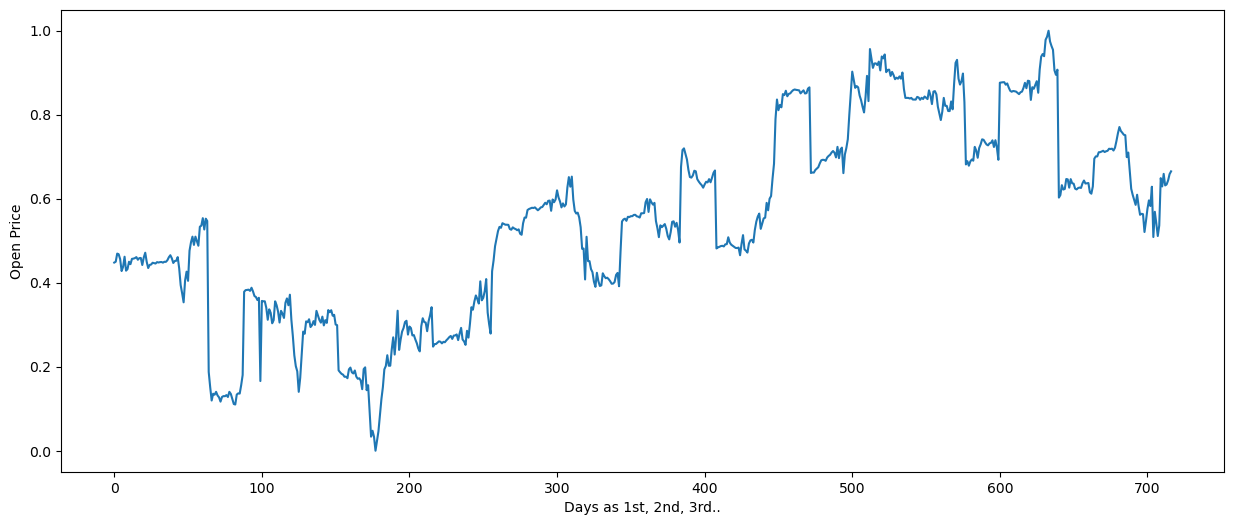

In [11]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

<a id="5"></a>
## 5.Creating X_train and y_train from Train data

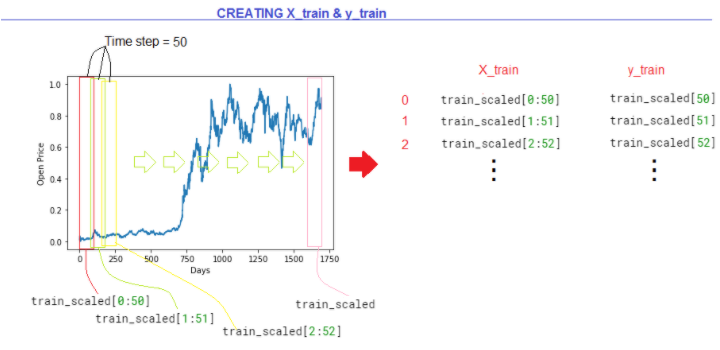

* We have train data composed of stock open prices over days
* So, it has 1184 prices corresponding 1184 days
* My aim is to predict the open price of the next day.
* I can use a time step of 50 days.
* I will pick first 50 open prices (0 to 50), 1st 50 price will be in X_train data
* Then predict the price of 51th day; and 51th price will be in y_train data
* Again, i will pick prices from 1 to 51, those will be in X_train data
* Then predict the next days price, 52nd price will be in y_train data

In [12]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)


In [13]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (667, 50)
Shape of y_train before reshape : (667,)


## Reshape

In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (667, 50, 1)
Shape of y_train after reshape : (667, 1)


* Shape of X_train : 1134 x 50 x 1
* That means we have 1134 rows, each row has 50 rows and 1 column
* Lets check the first row: it has 50 rows (open prices of 49 days)

In [15]:
X_train[0]

array([[0.44798206],
       [0.44992526],
       [0.46935725],
       [0.46786248],
       [0.45620329],
       [0.42780269],
       [0.43796712],
       [0.46188341],
       [0.42869955],
       [0.43258595],
       [0.44992526],
       [0.44424514],
       [0.4568012 ],
       [0.4573991 ],
       [0.45859492],
       [0.46098655],
       [0.45470852],
       [0.45859492],
       [0.45889387],
       [0.44215247],
       [0.46008969],
       [0.47144993],
       [0.44962631],
       [0.43497758],
       [0.44245142],
       [0.44334828],
       [0.44753363],
       [0.44663677],
       [0.44573991],
       [0.4490284 ],
       [0.44813154],
       [0.4490284 ],
       [0.44932735],
       [0.44783259],
       [0.44992526],
       [0.44962631],
       [0.45351271],
       [0.46068759],
       [0.46547085],
       [0.45829596],
       [0.44699552],
       [0.45165919],
       [0.452287  ],
       [0.46098655],
       [0.43426009],
       [0.39431988],
       [0.37488789],
       [0.353

* Check the first item in y_train
* It is the price of 50th day

In [16]:
y_train[0]

array([0.4044843])

<a id="6"></a>
## 6.Creating RNN model 

In [17]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 128)

Epoch 1/100


2023-10-18 12:11:26.737414: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6/6 [==============================] - 1s 22ms/step - loss: 0.4369 - accuracy: 0.0030
Epoch 2/100
6/6 [==============================] - 0s 21ms/step - loss: 0.2512 - accuracy: 0.0015
Epoch 3/100
6/6 [==============================] - 0s 21ms/step - loss: 0.2459 - accuracy: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 0s 21ms/step - loss: 0.2223 - accuracy: 0.0015
Epoch 5/100
6/6 [==============================] - 0s 22ms/step - loss: 0.2243 - accuracy: 0.0015
Epoch 6/100
6/6 [==============================] - 0s 22ms/step - loss: 0.1860 - accuracy: 0.0015
Epoch 7/100
6/6 [==============================] - 0s 24ms/step - loss: 0.1707 - accuracy: 0.0015
Epoch 8/100
6/6 [==============================] - 0s 22ms/step - loss: 0.1679 - accuracy: 0.0030
Epoch 9/100
6/6 [==============================] - 0s 22ms/step - loss: 0.1396 - accuracy: 0.0030
Epoch 10/100
6/6 [==============================] - 0s 22ms/step - loss: 0.1106 - accuracy: 0.0015
Epoch 11/100
6/6 [=========

6/6 [==============================] - 0s 23ms/step - loss: 0.0175 - accuracy: 0.0030
Epoch 84/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0186 - accuracy: 0.0030
Epoch 85/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0175 - accuracy: 0.0030
Epoch 86/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0177 - accuracy: 0.0030
Epoch 87/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0158 - accuracy: 0.0030
Epoch 88/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0180 - accuracy: 0.0030
Epoch 89/100
6/6 [==============================] - 0s 22ms/step - loss: 0.0176 - accuracy: 0.0030
Epoch 90/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0178 - accuracy: 0.0030
Epoch 91/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0176 - accuracy: 0.0030
Epoch 92/100
6/6 [==============================] - 0s 23ms/step - loss: 0.0161 - accuracy: 0.0030
Epoch 93/100
6/6 [=====

<a id="7"></a>
## 7.Evaluating Model

In [18]:
# Losses
history.history["loss"]

[0.4368870258331299,
 0.2512490451335907,
 0.24592389166355133,
 0.22231367230415344,
 0.2243078202009201,
 0.18599550426006317,
 0.1706831157207489,
 0.1679280698299408,
 0.1396036148071289,
 0.1106293797492981,
 0.12406723201274872,
 0.13566318154335022,
 0.1213529109954834,
 0.12924854457378387,
 0.12038026005029678,
 0.1117328628897667,
 0.10857075452804565,
 0.10655171424150467,
 0.09606238454580307,
 0.09267254173755646,
 0.09232430160045624,
 0.09385893493890762,
 0.080997034907341,
 0.08178085088729858,
 0.07676193118095398,
 0.07225291430950165,
 0.08254547417163849,
 0.07090187072753906,
 0.06417489051818848,
 0.07025620341300964,
 0.06232531741261482,
 0.06419964134693146,
 0.06228061020374298,
 0.06495324522256851,
 0.06184075400233269,
 0.05332721024751663,
 0.054160792380571365,
 0.05058298259973526,
 0.05597870796918869,
 0.04627291113138199,
 0.04614316299557686,
 0.04703773558139801,
 0.04071459919214249,
 0.043848514556884766,
 0.04320880025625229,
 0.0453133620321750

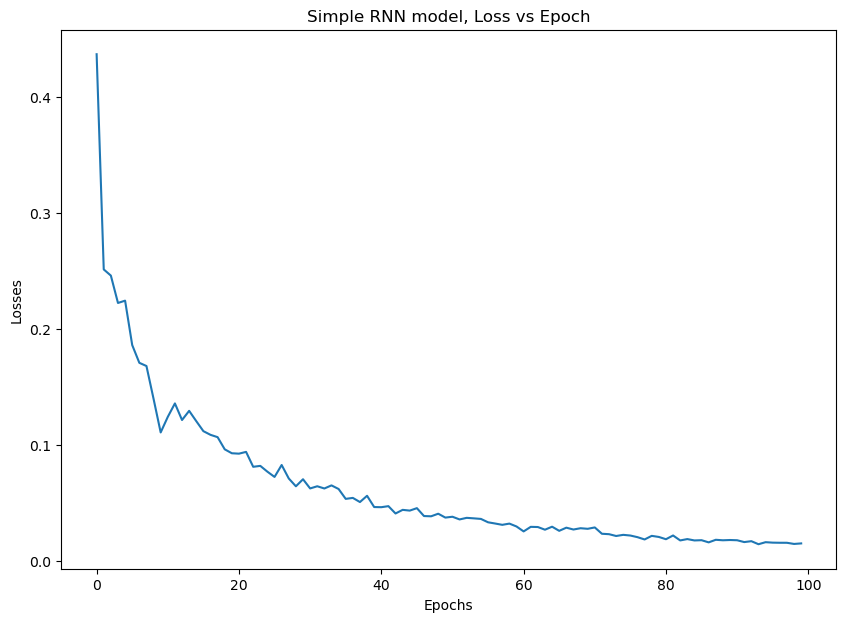

In [19]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

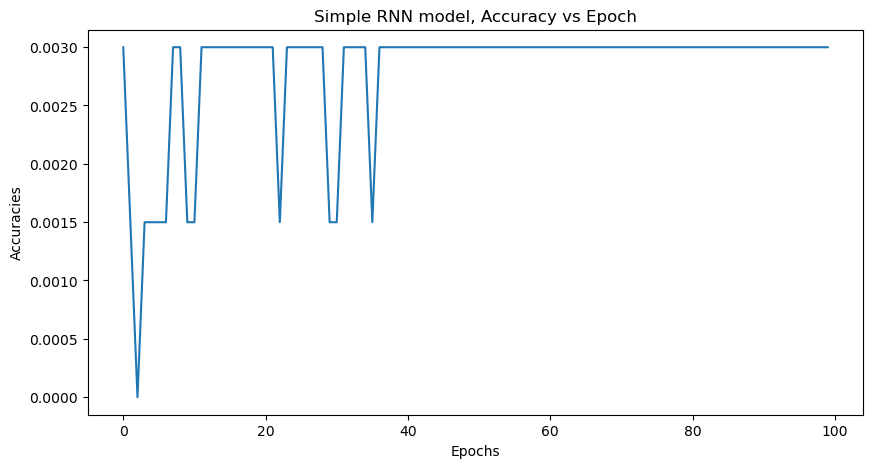

In [20]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

## Model predictions for train data 

In [21]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

21/21 [==============================] - 0s 3ms/step


(667, 1)

In [22]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(667, 1)

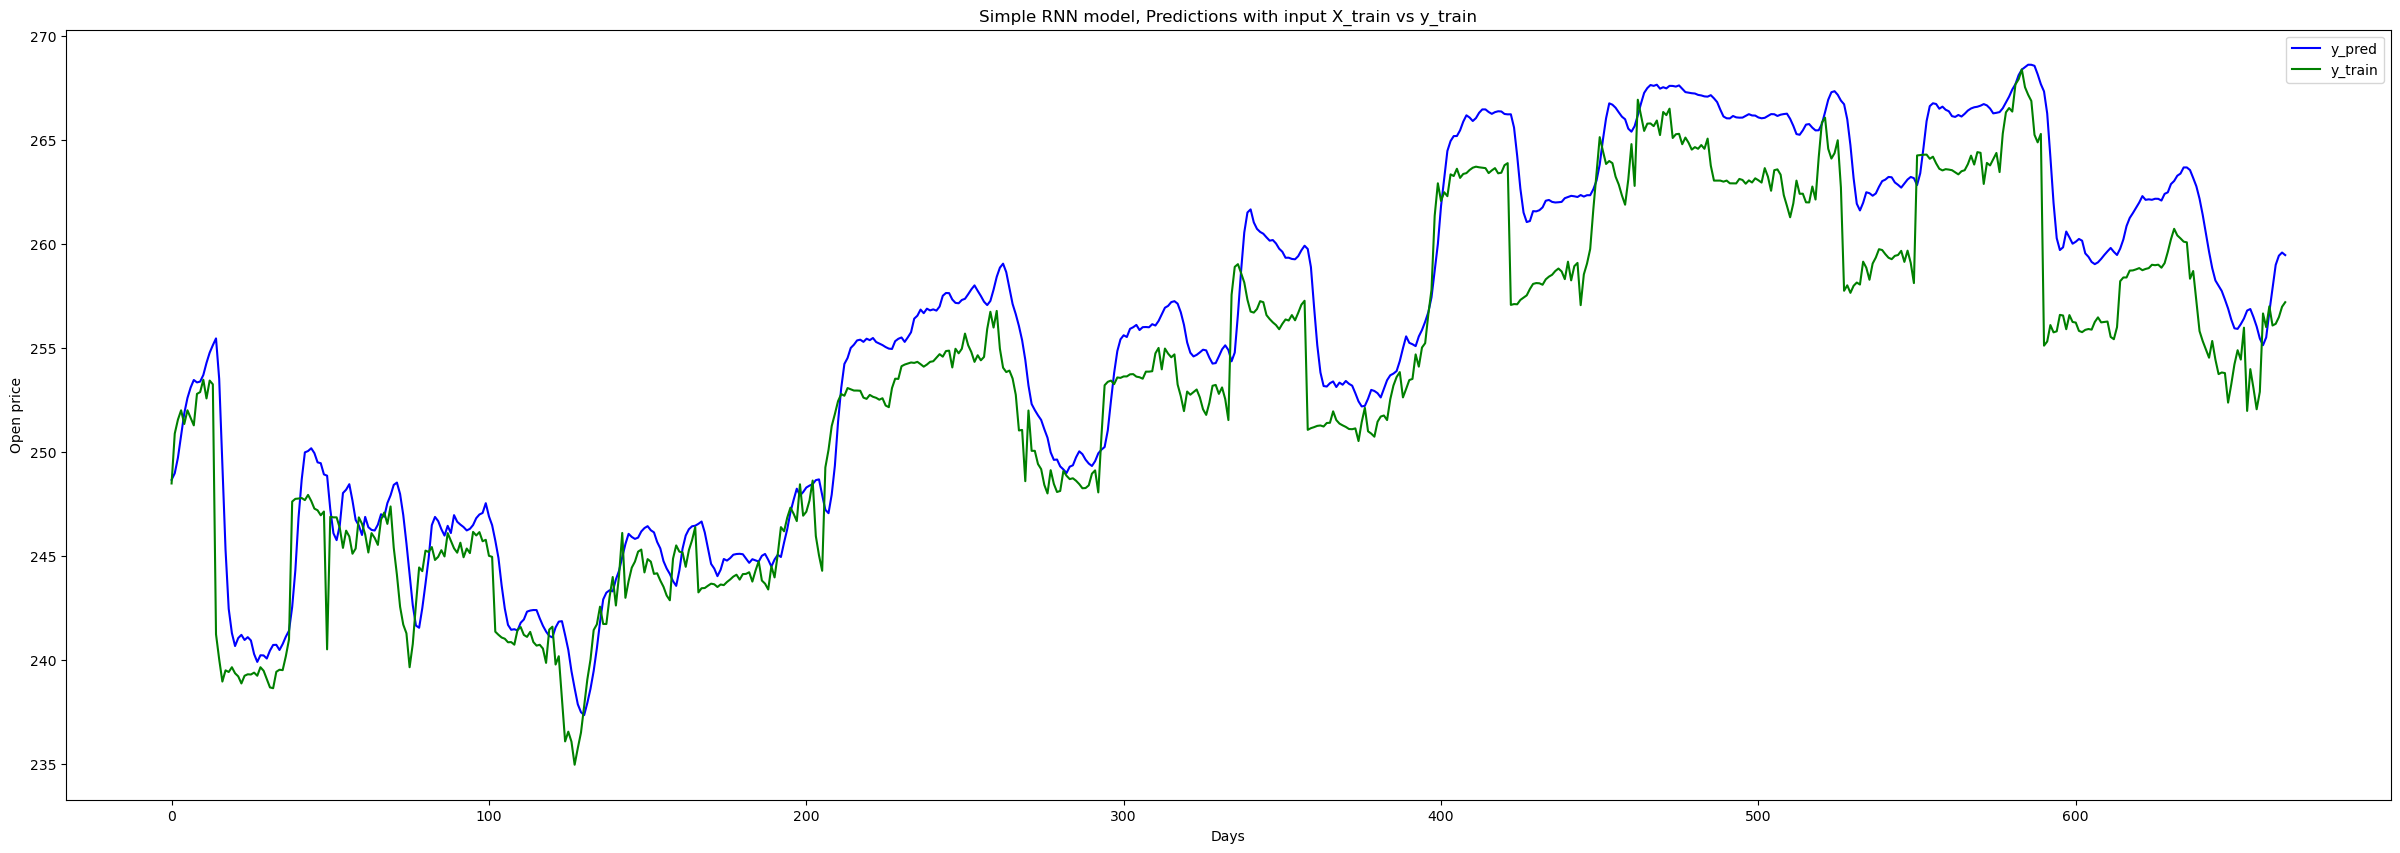

In [23]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()


<a id="8"></a>
## 8.Creando el conjunto de datos de prueba desde los datos de  Validación 

### Converting array and scaling

In [24]:
dataset_validation = validation_data.Open.values  # getting "open" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (307, 1)


### Creating X_test and y_test

In [25]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

### Converting to array

In [26]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [27]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (257, 50)
Shape of y_test before reshape : (257,)


### Reshape

In [28]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [29]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test after reshape : (257, 50, 1)
Shape of y_test after reshape : (257, 1)


<a id="9"></a>
## 9.Evaluando con los datos de validación

In [30]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

9/9 [==============================] - 0s 4ms/step
Shape of y_pred_of_test : (257, 1)


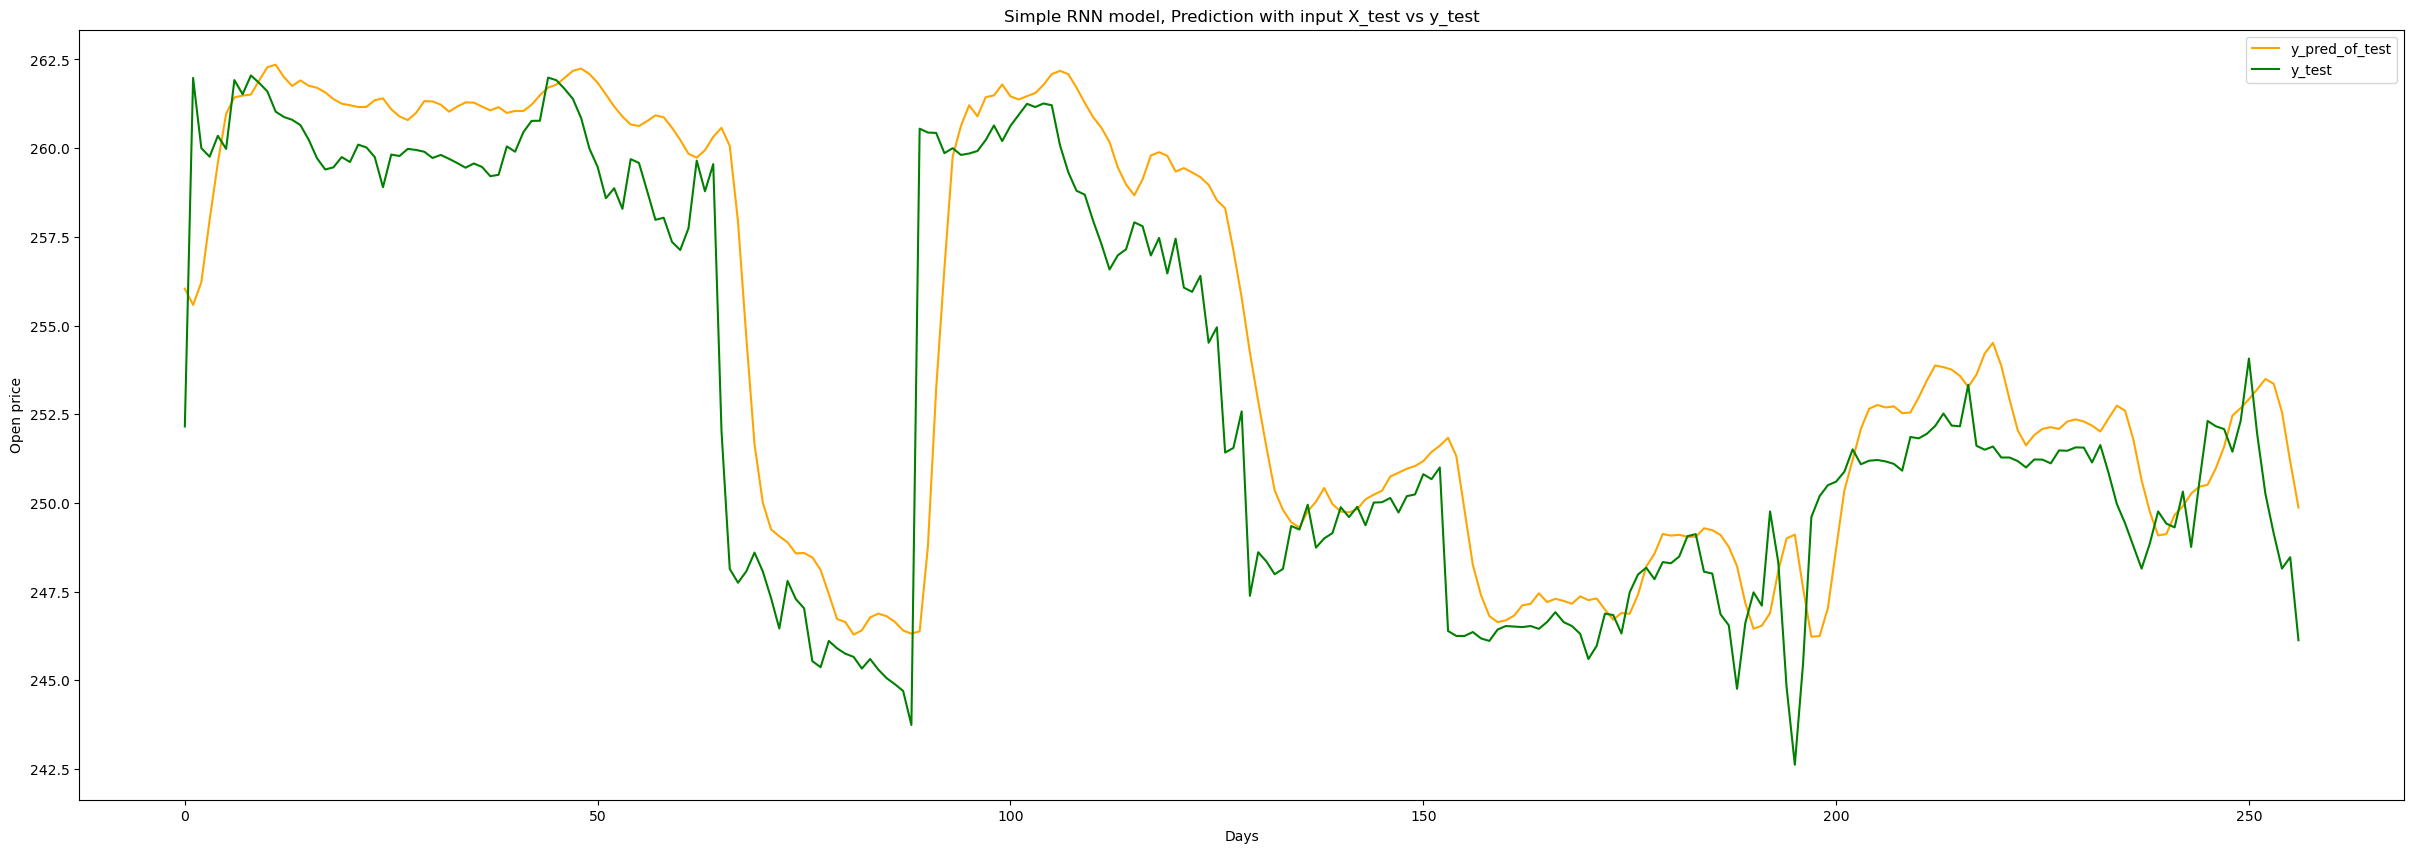

In [31]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

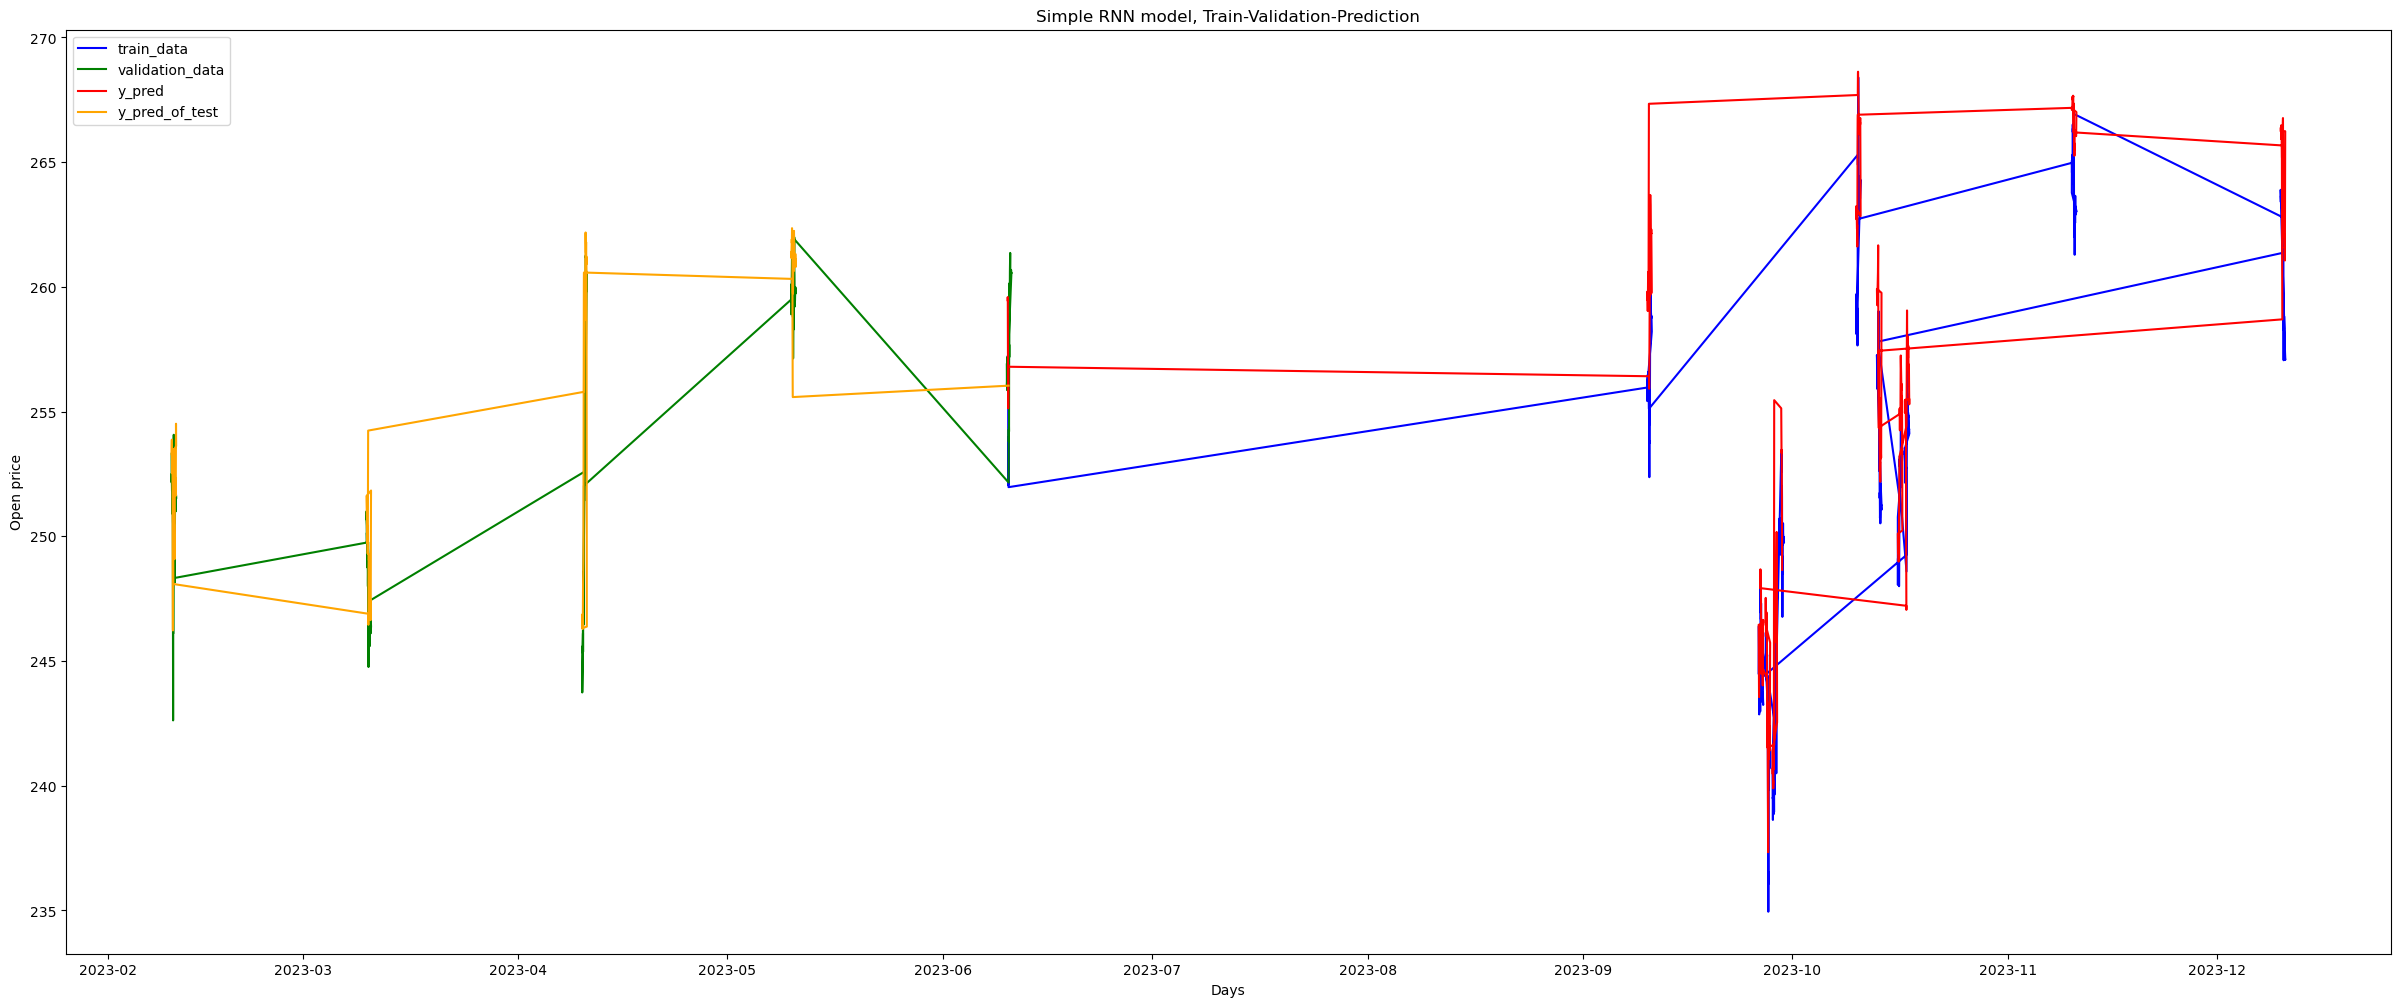

In [32]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Open, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Open, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

<a id="10"></a>
## 10.Creando el Modelo LSTM 

In [33]:
y_train = scaler.fit_transform(y_train)

In [34]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 40, batch_size = 40)


Epoch 1/40


2023-10-18 12:11:43.274078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 12:11:43.274606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 12:11:43.275202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

17/17 [==============================] - 1s 19ms/step - loss: 0.0766 - accuracy: 0.0015
Epoch 2/40
17/17 [==============================] - 0s 20ms/step - loss: 0.0120 - accuracy: 0.0030
Epoch 3/40
17/17 [==============================] - 0s 20ms/step - loss: 0.0082 - accuracy: 0.0030
Epoch 4/40
17/17 [==============================] - 0s 19ms/step - loss: 0.0066 - accuracy: 0.0030
Epoch 5/40
17/17 [==============================] - 0s 18ms/step - loss: 0.0062 - accuracy: 0.0030
Epoch 6/40
17/17 [==============================] - 0s 18ms/step - loss: 0.0058 - accuracy: 0.0030
Epoch 7/40
17/17 [==============================] - 0s 20ms/step - loss: 0.0057 - accuracy: 0.0030
Epoch 8/40
17/17 [==============================] - 0s 21ms/step - loss: 0.0054 - accuracy: 0.0030
Epoch 9/40
17/17 [==============================] - 0s 22ms/step - loss: 0.0052 - accuracy: 0.0030
Epoch 10/40
17/17 [==============================] - 0s 21ms/step - loss: 0.0052 - accuracy: 0.0030
Epoch 11/40
17/17 [=

<a id="11"></a>
## 11.Evaluando el modelo LSTM

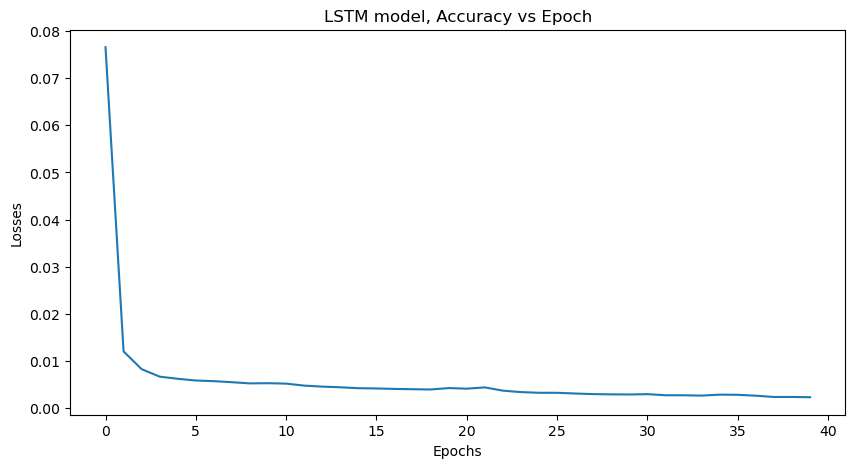

In [35]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

1/9 [==>...........................] - ETA: 2s

2023-10-18 12:11:58.238352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-18 12:11:58.239232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-18 12:11:58.239748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 0s 5ms/step


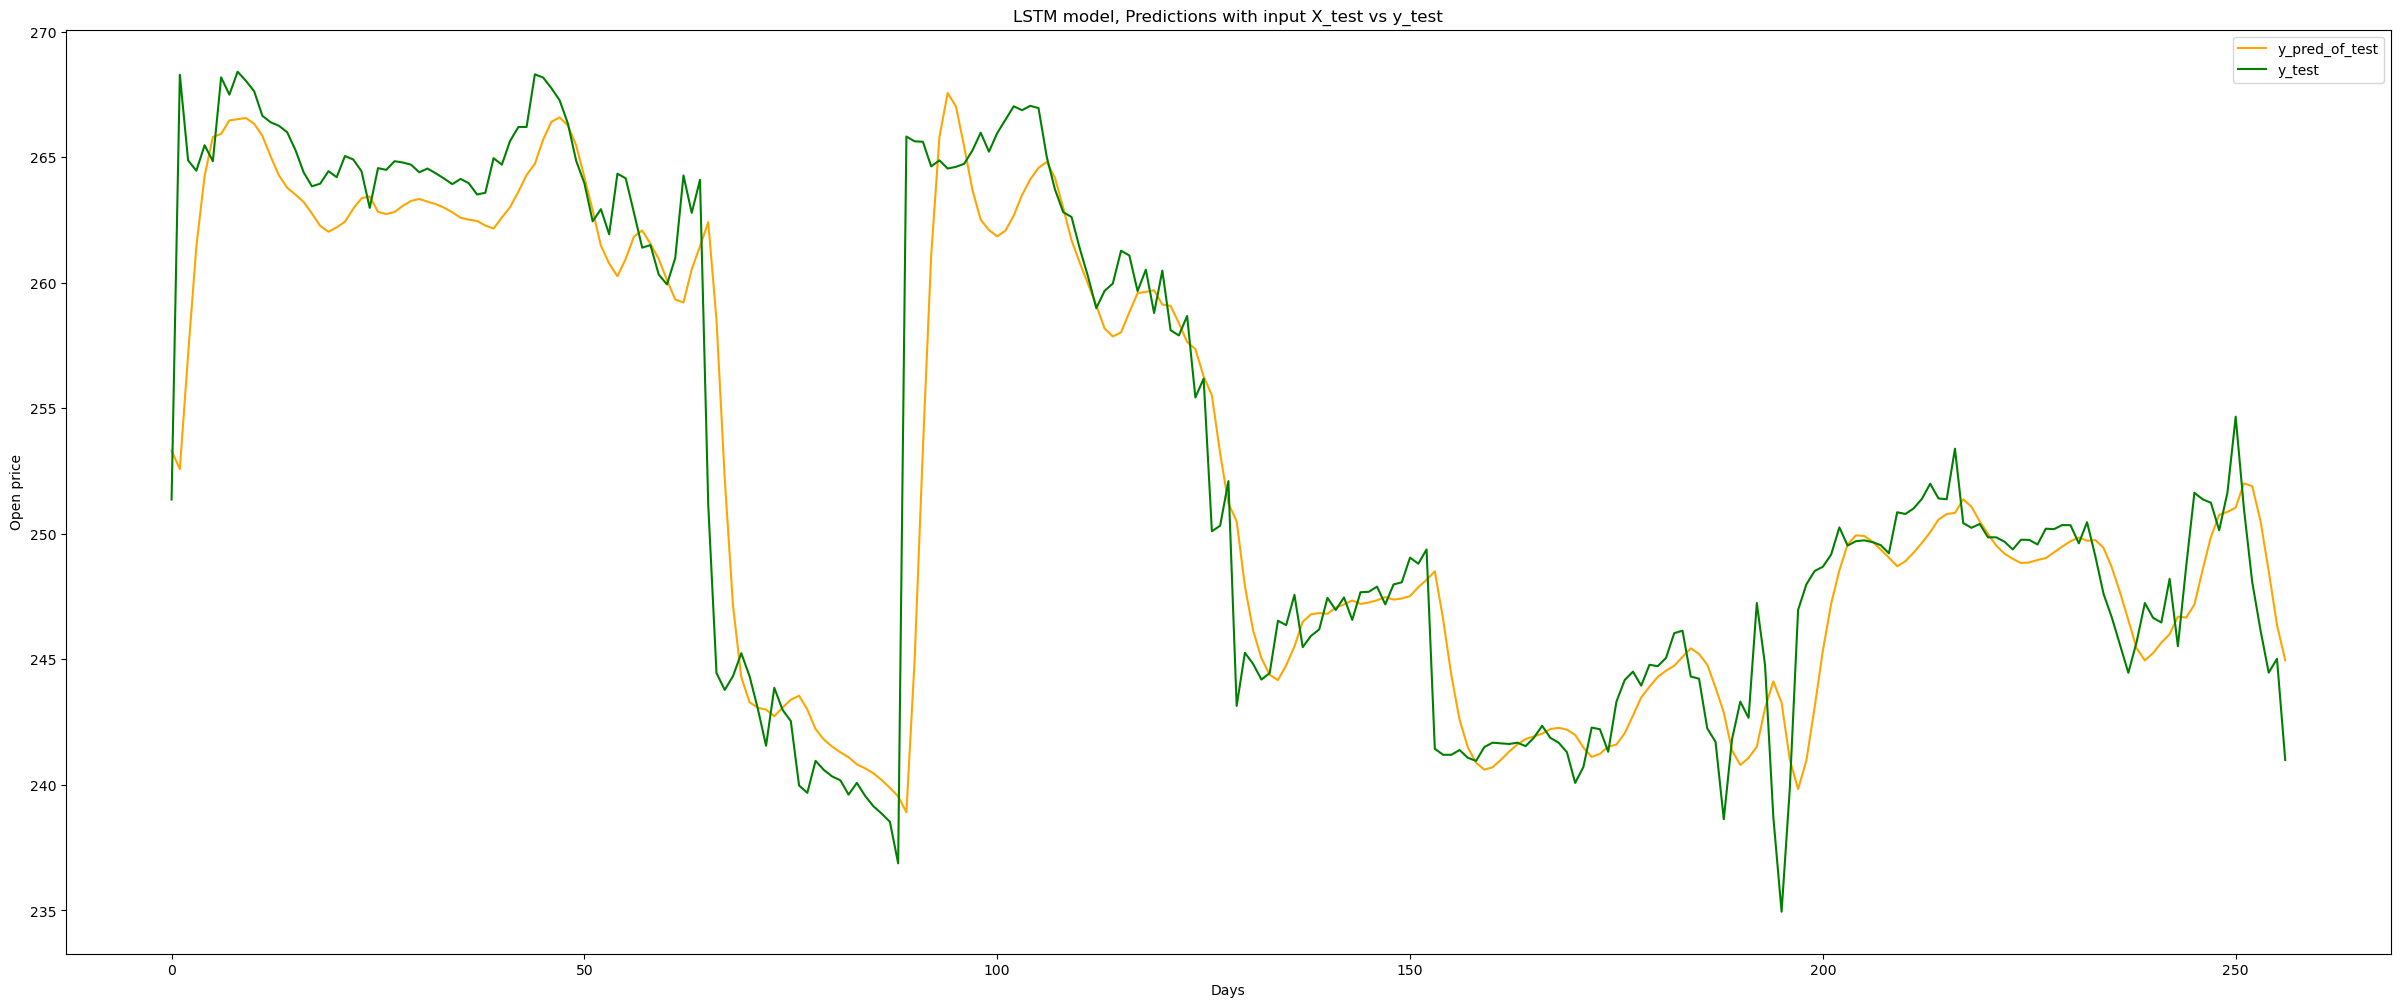

In [36]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

<a id="12"></a>
## 12.Predicción futura

* Which day is the last day in our data?

In [37]:
data.iloc[-1]

Date      02/10/23 10:00
Open              246.13
High              249.91
Low               245.82
Close             248.46
Volume           7990811
Name: 743, dtype: object

* We can predict the open price for the day after 3/17/2017--> for  3/18/2017.
* We will use last 50 days Open price as input of our model for this prediction
* Let us prepare it:

In [38]:
X_input = data.iloc[-time_step:].Open.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (1, 50, 1)


array([[[0.62594458],
        [0.60201511],
        [0.72166247],
        [0.71662469],
        [0.73299748],
        [0.76070529],
        [0.80478589],
        [0.76196474],
        [0.75944584],
        [0.90680101],
        [0.69017632],
        [0.67632242],
        [0.68765743],
        [0.64861461],
        [0.64861461],
        [0.63602015],
        [0.61335013],
        [0.64168766],
        [0.64105793],
        [0.62783375],
        [0.67380353],
        [0.67254408],
        [0.68450882],
        [0.68387909],
        [0.63098237],
        [0.69269521],
        [0.59382872],
        [0.4836272 ],
        [0.41498741],
        [0.33501259],
        [0.25403023],
        [0.34382872],
        [0.45717884],
        [0.41397985],
        [0.40050378],
        [0.52770781],
        [0.33123426],
        [0.56297229],
        [0.77833753],
        [0.75944584],
        [0.74937028],
        [0.66926952],
        [0.77884131],
        [1.        ],
        [0.73173804],
        [0

In [39]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Open price prediction:", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction:", LSTM_prediction[0,0])

1/1 [==============================] - 0s 10ms/step
Simple RNN, Open price prediction: 249.08035
LSTM prediction, Open price prediction: 247.39021
